In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import kendalltau, pearsonr, spearmanr

# Function to check results from the database
def check_results_in_db(conn, descriptor, model_name, seed):
    query = """
    SELECT y_true, y_pred, molregno FROM cs_mdfps_schema.model_descriptor_results 
    WHERE descriptor=%s AND model=%s AND seed=%s
    """
    cur = conn.cursor()
    cur.execute(query, (descriptor, model_name, seed))
    results = cur.fetchone()
    cur.close()
    return results

# Metric functions
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def get_kendall_tau(y_true, y_pred):
    return kendalltau(y_true, y_pred).correlation

def get_pearson_r(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

def get_spearman_rho(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

def get_fraction_withing_1_log(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)) < 1)

# Adjusted bootstrap function to return all sample statistics
def bootstrap_error_estimate(pred, truth, method, alpha=0.95, sample_frac=0.9, iterations=10):
    stats = []
    num_samples = int(len(pred) * sample_frac)
    for _ in range(iterations):
        sample_idx = resample(range(len(pred)), n_samples=num_samples)
        pred_sample = [pred[x] for x in sample_idx]
        truth_sample = [truth[x] for x in sample_idx]
        stats.append(method(pred_sample, truth_sample))
    lower = np.percentile(stats, ((1.0 - alpha) / 2.0) * 100)
    upper = np.percentile(stats, (alpha + ((1.0 - alpha) / 2.0)) * 100)
    median = method(pred, truth)
    return lower, upper, median, stats

# Function to compute CI and return all values
def model_90_ci(pred, truth, method, method_name="", alpha=0.95):
    stats_per_range = {}
    
    for pred_sample, truth_sample in zip(pred, truth):
        pred_sample = np.array(pred_sample)
        truth_sample = np.array(truth_sample)
        for range_start in range(-12, 10, 1):  # Iterate over dynamic ranges of truth
            mask = (truth_sample >= range_start) & (truth_sample < range_start + 3)
            if np.sum(mask) > 5:  # Ensure there are enough data points in the range
                if range_start not in stats_per_range:
                    stats_per_range[range_start] = []
                stats_per_range[range_start].append(method(pred_sample[mask], truth_sample[mask]))

    ci_results = {}
    all_stats_per_range = {}
    
    for range_start, stats in stats_per_range.items():
        p_lower = ((1.0 - alpha) / 2.0) * 100
        p_upper = (alpha + ((1.0 - alpha) / 2.0)) * 100
        lower = np.percentile(stats, p_lower)
        upper = np.percentile(stats, p_upper)
        median = np.median(stats)
        
        ci_results[range_start] = {
            'lower': lower,
            'upper': upper,
            'median': median,
            'all_values': stats  # Store all values
        }
    
    return ci_results

# Connect to the database
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=lebanon")
descriptor = 'RDKit_PhysChem'
models_to_evaluate = ['MultilinearRegression', 'RidgeRegression', 'Lasso', 'PLS', 'RandomForest', 'XGBoost', 'NeuralNetwork']

# Retrieve model results
predictions_lol, y_list_lol = [], []
for model_name in models_to_evaluate:
    predictions, y_list = [], []
    for i in range(10):  # Iterate over 10 splits
        result = check_results_in_db(conn, descriptor, model_name, i)
        if result:
            y_true, y_pred, _ = result
            predictions.append(y_pred)
            y_list.append(y_true)
    predictions_lol.append(predictions)
    y_list_lol.append(y_list)

# Calculate metrics for model results
model_results = {
    'Source': [], 'Model': [], 'Range': [], 'Metric': [],
    'Lower': [], 'Upper': [], 'Median': [], 'All_Values': []
}

for i, model_name in enumerate(models_to_evaluate):
    for method in [r2_score, root_mean_squared_error, mean_absolute_error, get_fraction_withing_1_log, get_kendall_tau, get_pearson_r, get_spearman_rho]:
        range_metrics = model_90_ci(predictions_lol[i], y_list_lol[i], method)
        
        for range_start, stats in range_metrics.items():
            model_results['Source'].append('Model')
            model_results['Model'].append(model_name)
            model_results['Range'].append(f"{range_start} to {range_start + 3}")          
            model_results['Metric'].append(method.__name__)
            model_results['Lower'].append(stats['lower'])
            model_results['Upper'].append(stats['upper'])           
            model_results['Median'].append(stats['median'])
            model_results['All_Values'].append(stats['all_values'])  # Add all values

# Convert to DataFrame
model_results_df = pd.DataFrame(model_results)

# Calculate metrics for experimental comparisons
bootstrap_results = {
    'Source': [], 'Model': [], 'Range': [], 'Metric': [],
    'Lower': [], 'Upper': [], 'Median': [], 'All_Values': []
}
df_vps = pd.read_csv('/localhome/cschiebroek/MDFP_VP/mdfptools/carl/group_talk_19_09_2024/vapor_pressures_naef_opera_duplicates.csv')
for i in range(-12, 10, 1):
    df_tmp = df_vps[(df_vps['VP OPERA'] >= i) & (df_vps['VP OPERA'] < i + 3)]
    if len(df_tmp) > 5:
        for method, method_name in [(get_kendall_tau, 'Kendall Tau'), (get_pearson_r, 'Pearson r'), (get_spearman_rho, 'Spearman rho'), 
                                    (r2_score, 'R2'), (root_mean_squared_error, 'RMSE'), (mean_absolute_error, 'MAE'), 
                                    (get_fraction_withing_1_log, 'Fraction within 1 log')]:
            lower, upper, median, all_values = bootstrap_error_estimate(df_tmp['VP Naef&Acree'].values, df_tmp['VP OPERA'].values, method)
            bootstrap_results['Source'].append('Experimental')
            bootstrap_results['Model'].append('Experimental Agreement')
            bootstrap_results['Range'].append(f"{i} to {i + 3}")
            bootstrap_results['Metric'].append(method_name)
            bootstrap_results['Lower'].append(lower)
            bootstrap_results['Upper'].append(upper)
            bootstrap_results['Median'].append(median)
            bootstrap_results['All_Values'].append(all_values)  # Add all values

# Convert to DataFrame
experimental_results_df = pd.DataFrame(bootstrap_results)
model_results_df['Metric'] = model_results_df['Metric'].replace({'r2_score': 'R2', 'root_mean_squared_error': 'RMSE', 'mean_absolute_error': 'MAE', 'get_fraction_withing_1_log': 'Fraction within 1 log', 'get_kendall_tau': 'Kendall Tau', 'get_pearson_r': 'Pearson r', 'get_spearman_rho': 'Spearman rho'})
combined_df = pd.concat([model_results_df, experimental_results_df], ignore_index=True)
combined_df['Model'] = combined_df['Model'].replace({'MultilinearRegression': 'Ordinary Least Squares'})


/tmp/ipykernel_2059608/2697207411.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', 256)


(-0.8500000000000001, 17.85)


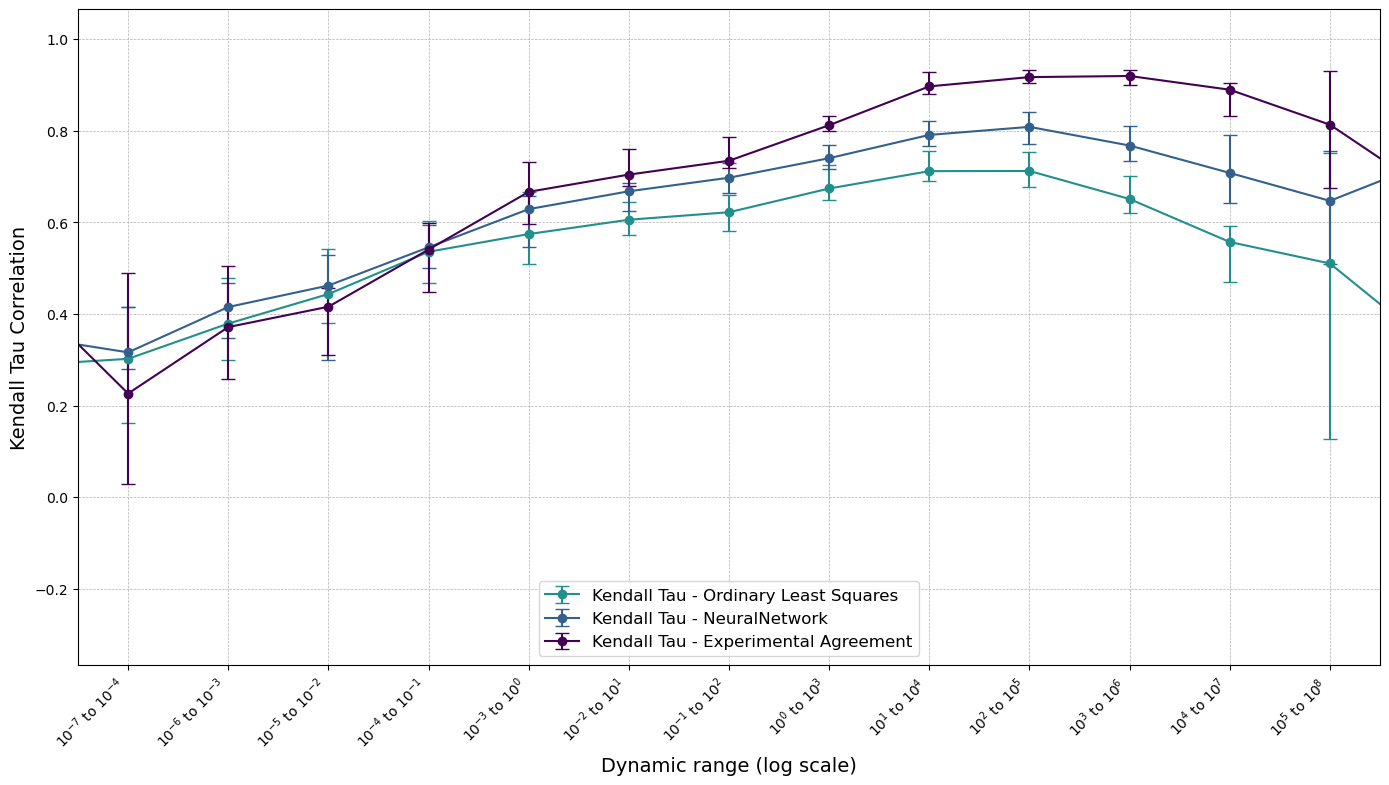

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
combined_df['Range Start'] = combined_df['Range'].apply(lambda x: int(x.split(' to ')[0]))
combined_df['Range End'] = combined_df['Range'].apply(lambda x: int(x.split(' to ')[1]))
#drop those with Range start value counts < max value count
max_range_start_value_count = combined_df['Range Start'].value_counts().max()
range_start_value_counts = combined_df['Range Start'].value_counts()
range_start_value_counts = range_start_value_counts[range_start_value_counts == max_range_start_value_count]
combined_df = combined_df[combined_df['Range Start'].isin(range_start_value_counts.index)]

# Sort the DataFrame by the numeric start of the range
combined_df.sort_values(by='Range Start', inplace=True)

#drop nans
combined_df = combined_df.dropna()

# Filter the combined DataFrame for relevant metrics and sources
filtered_df = combined_df[
    (combined_df['Metric'] == 'Kendall Tau') &
    (combined_df['Model'].isin(['Ordinary Least Squares', 'NeuralNetwork', 'Experimental Agreement']))
]

# Set up colors
colors = cm.get_cmap('viridis', 256)
colors = colors(np.linspace(0, 1, 256))
colors = colors[:128][::-1]
c1, c2, c3 = colors[0], colors[50], colors[-1]  # Use distinct colors for each line

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Kendall Tau for each source
sources = ['Ordinary Least Squares', 'NeuralNetwork', 'Experimental Agreement']
colors_map = [c1, c2, c3]
for source, color in zip(sources, colors_map):
    subset = filtered_df[filtered_df['Model'] == source]
    lb = subset['Median'] - subset['Lower']
    ub = subset['Upper'] - subset['Median']

    ax1.errorbar(
        subset['Range'], subset['Median'],
        yerr=[lb, ub],
        fmt='o-', capsize=5, color=color,
        label=f'Kendall Tau - {source}'
    )

# Customize the first axis
ax1.set_xlabel('Dynamic range (log scale)', fontsize=14)
ax1.set_ylabel('Kendall Tau Correlation', fontsize=14)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(visible=True, linestyle='--', linewidth=0.5)

# Customize the x-tick labels if needed
log_ranges_lower = [int(r.split(' to ')[0]) for r in filtered_df['Range'].unique()]
log_ranges_upper = [int(r.split(' to ')[1]) for r in filtered_df['Range'].unique()]
xtick_labels = [f'$10^{{{lower}}}$ to $10^{{{upper}}}$' for lower, upper in zip(log_ranges_lower, log_ranges_upper)]

ax1.set_xticks(np.arange(len(log_ranges_lower)))
ax1.set_xticklabels(xtick_labels, rotation=45, ha='right')

# Combine and show legend
ax1.legend(loc='lower center', fontsize=12)

# Set a tight layout
plt.tight_layout()

# Save the plot
plt.savefig('kendall_tau_comparison.png', dpi=800)
#print x range, adjust it later
print(plt.gca().get_xlim())
plt.xlim(3.5,16.5)
# Display the plot
plt.show()


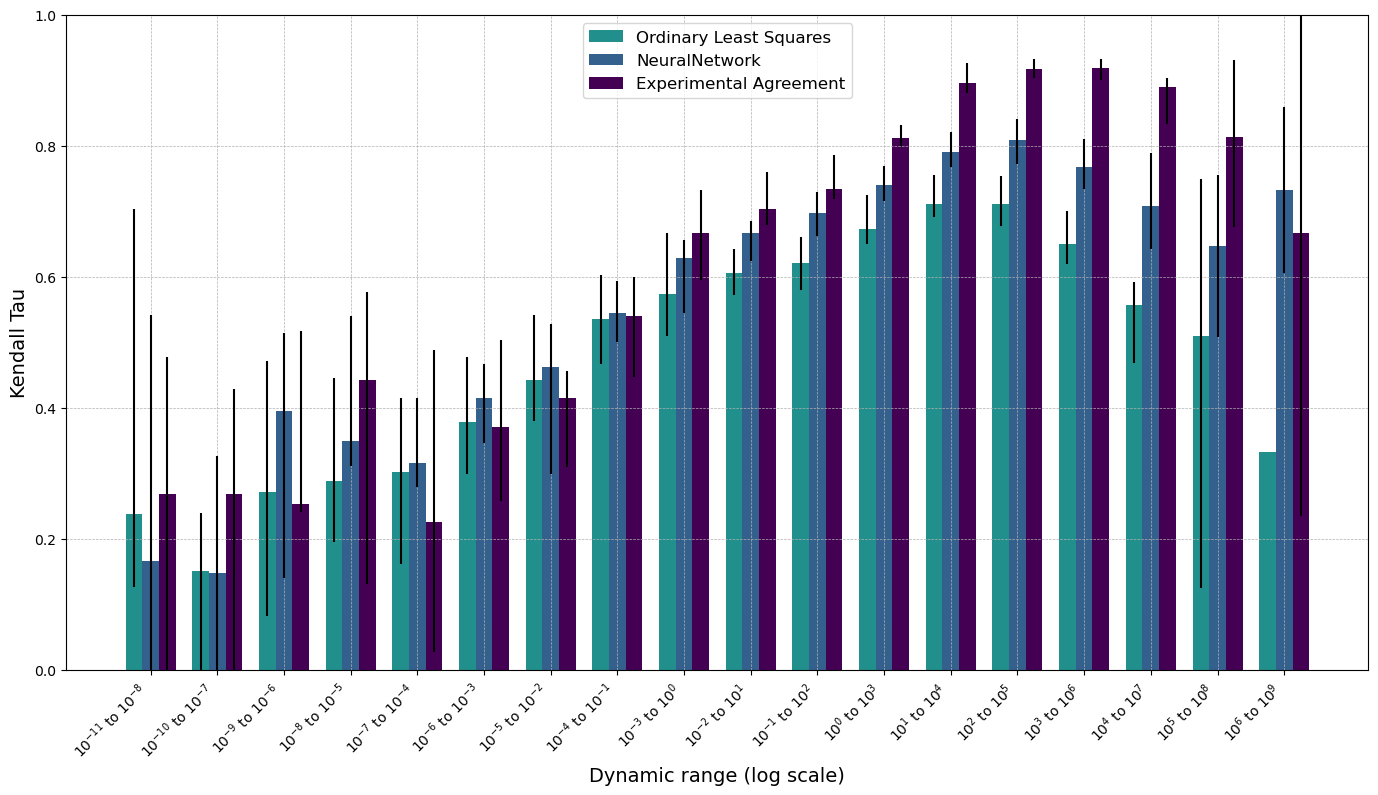

In [13]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot Kendall Tau for each source
sources = ['Ordinary Least Squares', 'NeuralNetwork', 'Experimental Agreement']
colors_map = [c1, c2, c3]

#set space between bars
bar_width = 0.25

#set position of bar on x axis
r1 = np.arange(len(filtered_df['Range'].unique()))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

for source, color, r in zip(sources, colors_map, [r1, r2, r3]):
    subset = filtered_df[filtered_df['Model'] == source]
    lb = subset['Median'] - subset['Lower']
    ub = subset['Upper'] - subset['Median']

    ax.bar(
        r, subset['Median'],
        yerr=[lb, ub],
        width=bar_width, color=color,
        label=f'Kendall Tau - {source}'
    )

# Customize the axis
ax.set_xlabel('Dynamic range (log scale)', fontsize=14)
ax.set_ylabel('Kendall Tau' , fontsize=14)
ax.set_xticks([r + bar_width for r in range(len(filtered_df['Range'].unique()))])
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')
ax.grid(visible=True, linestyle='--', linewidth=0.5)

# Combine and show legend
ax.legend(loc='upper center', fontsize=12)
#remove Kendall Tau -  from legend strings
handles, labels = ax.get_legend_handles_labels()
labels = [label.replace('Kendall Tau - ', '') for label in labels]
ax.legend(handles, labels, loc='upper center', fontsize=12)


# Set a tight layout
plt.tight_layout()

# plt.xlim(3.7,16.8)
plt.ylim(0,1)
# Display the plot
#save
plt.savefig('kendall_tau_comparison_bars.png', dpi=800)
plt.show()


Range: -9 to -6
Range: -8 to -5
Significant
OLS = NN
OLS < Exp
NN = Exp
Range: -7 to -4
Range: -6 to -3
Range: -5 to -2
Significant
OLS = NN
OLS > Exp
NN = Exp
Range: -4 to -1
Range: -3 to 0
Significant
OLS = NN
OLS < Exp
NN < Exp
Range: -2 to 1
Significant
OLS < NN
OLS < Exp
NN < Exp
Range: -1 to 2
Significant
OLS < NN
OLS < Exp
NN < Exp
Range: 0 to 3
Significant
OLS < NN
OLS < Exp
NN < Exp
Range: 1 to 4
Significant
OLS < NN
OLS < Exp
NN < Exp
Range: 2 to 5
Significant
OLS < NN
OLS < Exp
NN < Exp
Range: 3 to 6
Significant
OLS < NN
OLS < Exp
NN < Exp
Range: 4 to 7
Significant
OLS < NN
OLS < Exp
NN < Exp
Range: 5 to 8
Significant
OLS = NN
OLS < Exp
NN < Exp
Friedman test p-value: 0.001984829580418221
Ordinary Least Squares = NeuralNetwork
Ordinary Least Squares > Experimental Agreement
NeuralNetwork > Experimental Agreement


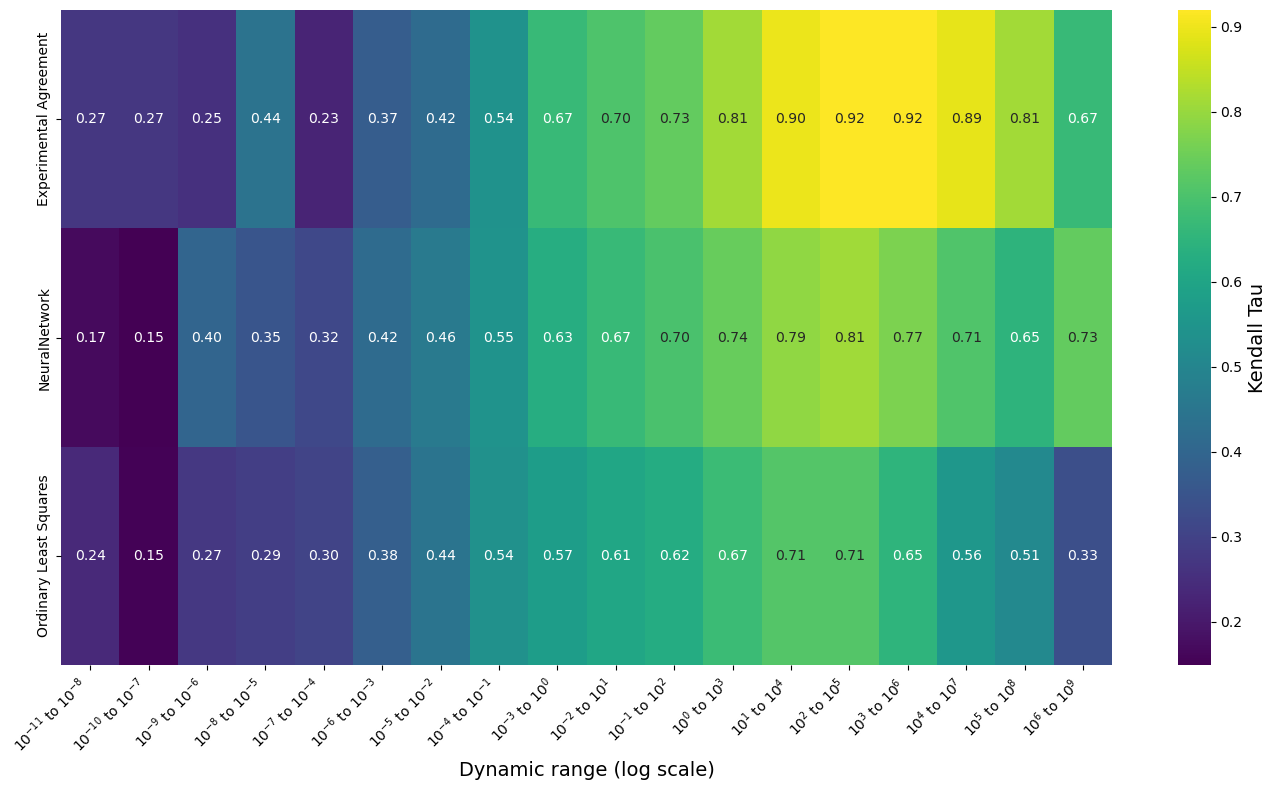

In [34]:
#friedman chi square test, for each range
from scipy.stats import friedmanchisquare
# Filter the combined DataFrame for relevant metrics and sources
filtered_df = combined_df[
    (combined_df['Metric'] == 'Kendall Tau') &
    (combined_df['Model'].isin(['Ordinary Least Squares', 'NeuralNetwork', 'Experimental Agreement']))
]

def get_significance_wilcoxon(nested_list,nested_list_names):
    from itertools import combinations
    comb = list(combinations(range(len(nested_list)), 2))
    for c in comb:
        w, p = wilcoxon(nested_list[c[0]], nested_list[c[1]])
        if p < 0.05:
            if np.mean(nested_list[c[0]]) > np.mean(nested_list[c[1]]):
                print(f'{nested_list_names[c[0]]} > {nested_list_names[c[1]]}')
            elif np.mean(nested_list[c[0]]) < np.mean(nested_list[c[1]]):
                print(f'{nested_list_names[c[0]]} < {nested_list_names[c[1]]}')
            else:
                print(f'{nested_list_names[c[0]]} = {nested_list_names[c[1]]}')
        else:
            print(f'{nested_list_names[c[0]]} = {nested_list_names[c[1]]}')


for range_start in filtered_df['Range Start'].unique():
    subset = filtered_df[filtered_df['Range Start'] == range_start]
    ols = subset[subset['Model'] == 'Ordinary Least Squares']['All_Values'].values[0]
    nn = subset[subset['Model'] == 'NeuralNetwork']['All_Values'].values[0]
    exp = subset[subset['Model'] == 'Experimental Agreement']['All_Values'].values[0]
    try:
        assert len(ols) == len(nn) == len(exp)
    except AssertionError:
        continue
    print(f'Range: {range_start} to {range_start + 3}')
    fcs = friedmanchisquare(ols, nn, exp)
    if fcs.pvalue < 0.05:
        print('Significant')
        get_significance_wilcoxon([ols,nn,exp],['OLS','NN','Exp'])

from scipy.stats import wilcoxon
from itertools import combinations
import seaborn as sns
# Filter the combined DataFrame for relevant metrics and sources
models = filtered_df['Model'].unique()


# Filter the combined DataFrame for relevant metrics and sources
filtered_df = combined_df[
    (combined_df['Metric'] == 'Kendall Tau') &
    (combined_df['Model'].isin(['Ordinary Least Squares', 'NeuralNetwork', 'Experimental Agreement']))
]

# Create a pivot table for the Kendall Tau values
pivot_df = filtered_df.pivot(index='Model', columns='Range Start', values='Median')

# Perform the Friedman test
fcs = friedmanchisquare(*[filtered_df[filtered_df['Model'] == model]['Median'] for model in filtered_df['Model'].unique()])
print(f'Friedman test p-value: {fcs.pvalue}')

# Perform the Wilcoxon test
models = filtered_df['Model'].unique()
comb = list(combinations(range(len(models)), 2))

for c in comb:
    w, p = wilcoxon(pivot_df.iloc[c[0]], pivot_df.iloc[c[1]])
    if p < 0.05:
        if np.mean(pivot_df.iloc[c[0]]) > np.mean(pivot_df.iloc[c[1]]):
            print(f'{models[c[0]]} > {models[c[1]]}')
        elif np.mean(pivot_df.iloc[c[0]]) < np.mean(pivot_df.iloc[c[1]]):
            print(f'{models[c[0]]} < {models[c[1]]}')
        else:
            print(f'{models[c[0]]} = {models[c[1]]}')
    else:
        print(f'{models[c[0]]} = {models[c[1]]}')

# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the Kendall Tau values
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='viridis', ax=ax)

# Customize the axis
ax.set_xlabel('Dynamic range (log scale)', fontsize=14)
ax.set_ylabel('Model', fontsize=14)

#change xticklabels to range (10^start - 10^end)
lowers = filtered_df['Range Start'].unique()
uppers = filtered_df['Range End'].unique()
xtick_labels = [f'$10^{{{lower}}}$ to $10^{{{upper}}}$' for lower, upper in zip(lowers, uppers)]
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

#remove y label
ax.set_ylabel('')

#add label to cbar
cbar = ax.collections[0].colorbar
cbar.set_label('Kendall Tau', fontsize=14)

# Set a tight layout
plt.tight_layout()




Range: -9
Range: -8
Significant
Range: -7
Range: -6
Range: -5
Significant
Range: -4
Range: -3
Significant
Range: -2
Significant
Range: -1
Significant
Range: 0
Significant
Range: 1
Significant
Range: 2
Significant
Range: 3
Significant
Range: 4
Significant
Range: 5
Significant


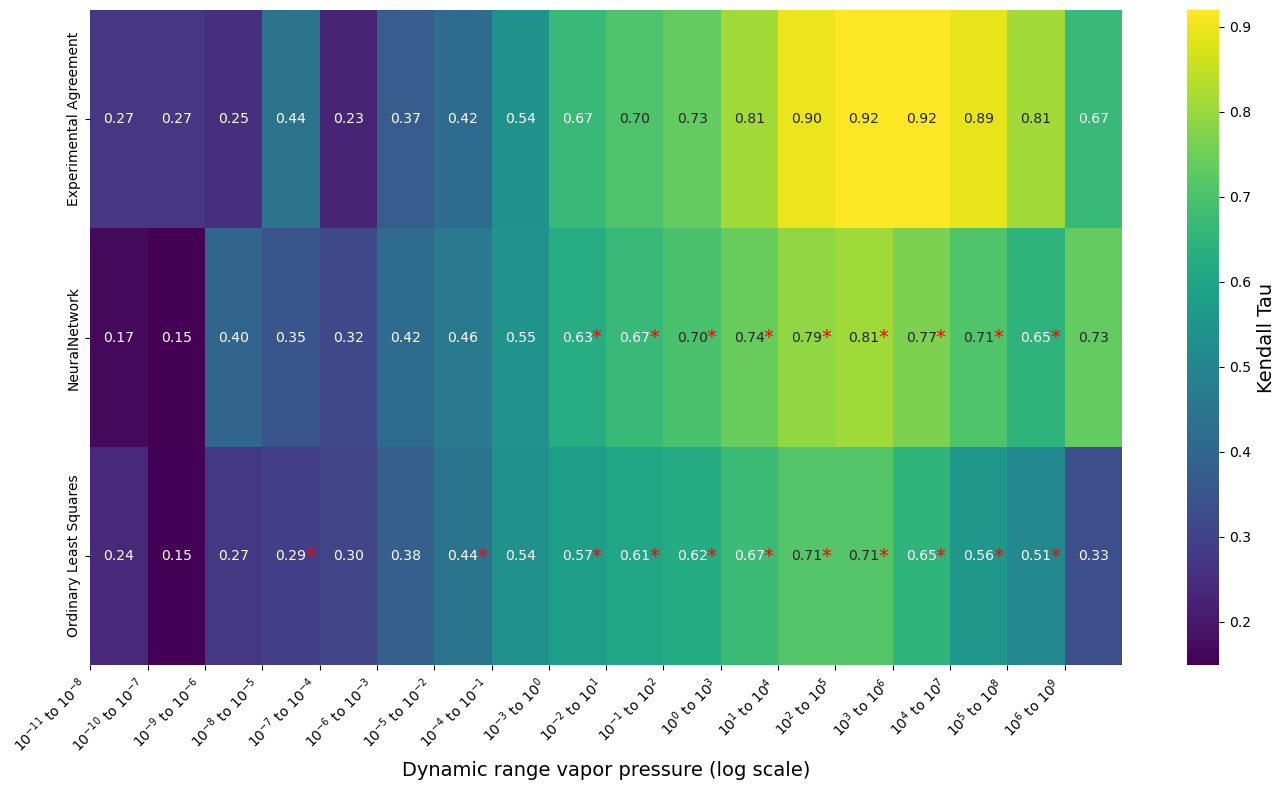

In [63]:
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure the combined DataFrame contains all relevant data for analysis
filtered_df = combined_df[
    (combined_df['Metric'] == 'Kendall Tau') &
    (combined_df['Model'].isin(['Ordinary Least Squares', 'NeuralNetwork', 'Experimental Agreement']))
]

# Function to get significance with Wilcoxon test and print results
def get_significance_wilcoxon(nested_list, nested_list_names):
    comb = list(combinations(range(len(nested_list)), 2))
    significance = {}
    for c in comb:
        w, p = wilcoxon(nested_list[c[0]], nested_list[c[1]])
        if p < 0.05:
            if np.mean(nested_list[c[0]]) > np.mean(nested_list[c[1]]):
                significance[(nested_list_names[c[0]], nested_list_names[c[1]])] = '>'
            elif np.mean(nested_list[c[0]]) < np.mean(nested_list[c[1]]):
                significance[(nested_list_names[c[0]], nested_list_names[c[1]])] = '<'
            else:
                significance[(nested_list_names[c[0]], nested_list_names[c[1]])] = '='
    return significance

# Perform the Friedman test and Wilcoxon post-hoc analysis for each range
significance_dict = {}
for range_start in filtered_df['Range Start'].unique():
    subset = filtered_df[filtered_df['Range Start'] == range_start]
    ols = subset[subset['Model'] == 'Ordinary Least Squares']['All_Values'].values[0]
    nn = subset[subset['Model'] == 'NeuralNetwork']['All_Values'].values[0]
    exp = subset[subset['Model'] == 'Experimental Agreement']['All_Values'].values[0]

    try:
        assert len(ols) == len(nn) == len(exp)
    except AssertionError:
        continue
    
    print(f'Range: {range_start}')
    fcs = friedmanchisquare(ols, nn, exp)
    if fcs.pvalue < 0.05:
        print('Significant')
        significance = get_significance_wilcoxon([ols, nn, exp], ['Ordinary Least Squares', 'NeuralNetwork', 'Experimental Agreement'])
        # Filter to include only comparisons involving 'Experimental Agreement'
        filtered_significance = {pair: rel for pair, rel in significance.items() if 'Experimental Agreement' in pair}
        significance_dict[range_start] = filtered_significance

# Prepare pivot DataFrame for plotting
pivot_df = filtered_df.pivot(index='Model', columns='Range Start', values='Median')
#sort columns by range start
pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)

# Create a heatmap with significance annotations
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='viridis', ax=ax)

# Annotate significant differences with stars positioned to the right of the text
for (range_start, significance) in significance_dict.items():
    col_idx = pivot_df.columns.get_loc(range_start)
    for (model1, model2), relation in significance.items():
        if relation != '=':
            row1 = pivot_df.index.get_loc(model1)
            row2 = pivot_df.index.get_loc(model2)
            if model1 == 'Experimental Agreement':
                ax.text(col_idx + 0.75, row2 + 0.5, '*', ha='left', va='center', color='red', fontsize=14)
            elif model2 == 'Experimental Agreement':
                ax.text(col_idx + 0.75, row1 + 0.5, '*', ha='left', va='center', color='red', fontsize=14)

# Customize x-axis labels to show dynamic range in log scale
lowers = filtered_df['Range Start'].unique()
uppers = filtered_df['Range End'].unique()
xtick_labels = [f'$10^{{{lower}}}$ to $10^{{{upper}}}$' for lower, upper in zip(lowers, uppers)]
ax.set_xticks(np.arange(len(xtick_labels)))
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')

# Add labels and adjust layout
ax.set_ylabel('')
cbar = ax.collections[0].colorbar
cbar.set_label('Kendall Tau', fontsize=14)

#change x label
ax.set_xlabel('Dynamic range vapor pressure (log scale)', fontsize=14)

plt.tight_layout()

plt.show()


Range: -9
Range: -8
Range: -7
Range: -6
Range: -5
Range: -4
Range: -3
Range: -2
Significant
Range: -1
Significant
Range: 0
Significant
Range: 1
Significant
Range: 2
Significant
Range: 3
Significant
Range: 4
Significant
Range: 5


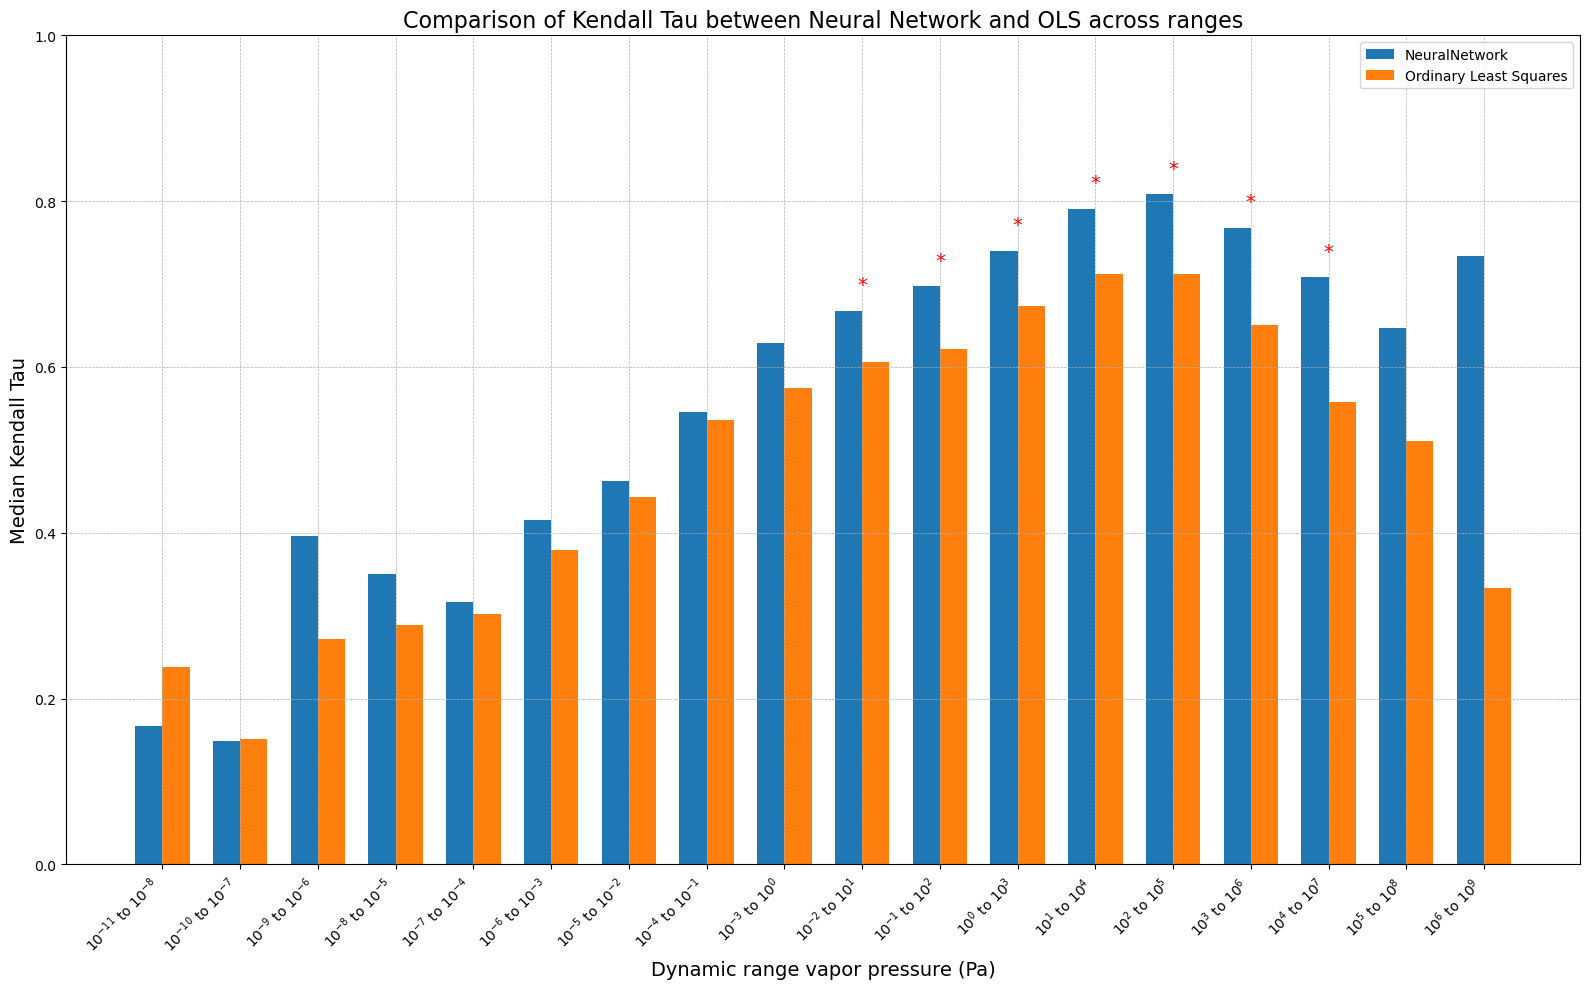

In [65]:
# Create a new significance dictionary for Neural Network and OLS comparisons only
significance_dict_nn_ols = {}
for range_start in filtered_df['Range Start'].unique():
    subset = filtered_df[filtered_df['Range Start'] == range_start]
    ols = subset[subset['Model'] == 'Ordinary Least Squares']['All_Values'].values[0]
    nn = subset[subset['Model'] == 'NeuralNetwork']['All_Values'].values[0]

    try:
        assert len(ols) == len(nn)
    except AssertionError:
        continue
    
    print(f'Range: {range_start}')
    # Perform the Wilcoxon test directly for OLS and Neural Network
    w, p = wilcoxon(ols, nn)
    if p < 0.05:
        print('Significant')
        if np.mean(ols) > np.mean(nn):
            significance_dict_nn_ols[range_start] = 'OLS > NN'
        else:
            significance_dict_nn_ols[range_start] = 'NN > OLS'

# Updated bar plot code
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for the bar plot
range_starts = nn_ols_df['Range Start'].unique()
neural_net_medians = nn_ols_df[nn_ols_df['Model'] == 'NeuralNetwork'].set_index('Range Start')['Median']
ols_medians = nn_ols_df[nn_ols_df['Model'] == 'Ordinary Least Squares'].set_index('Range Start')['Median']

# Set bar width and positions
bar_width = 0.35
x = np.arange(len(range_starts))

# Create bar plot
fig, ax = plt.subplots(figsize=(16, 10))
bars1 = ax.bar(x - bar_width/2, neural_net_medians, bar_width, label='NeuralNetwork')
bars2 = ax.bar(x + bar_width/2, ols_medians, bar_width, label='Ordinary Least Squares')

# Add significance markers above the bars
for i, range_start in enumerate(range_starts):
    if range_start in significance_dict_nn_ols:
        y_max = max(neural_net_medians[range_start], ols_medians[range_start])
        ax.text(
            i, 
            y_max + 0.02,  # Adjust this value for clearer visibility
            '*', 
            ha='center', 
            va='bottom', 
            color='red', 
            fontsize=14
        )

# Customize the plot
ax.set_xlabel('Dynamic range vapor pressure (Pa)', fontsize=14)
ax.set_ylabel('Median Kendall Tau', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(xtick_labels, rotation=45, ha='right')
ax.set_ylim(0, 1)  # Adjust the y-axis to fit all data points and markers
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
ax.set_title('Comparison of Kendall Tau between Neural Network and OLS across ranges', fontsize=16)

plt.tight_layout()
plt.show()


/tmp/ipykernel_2059608/2545387396.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


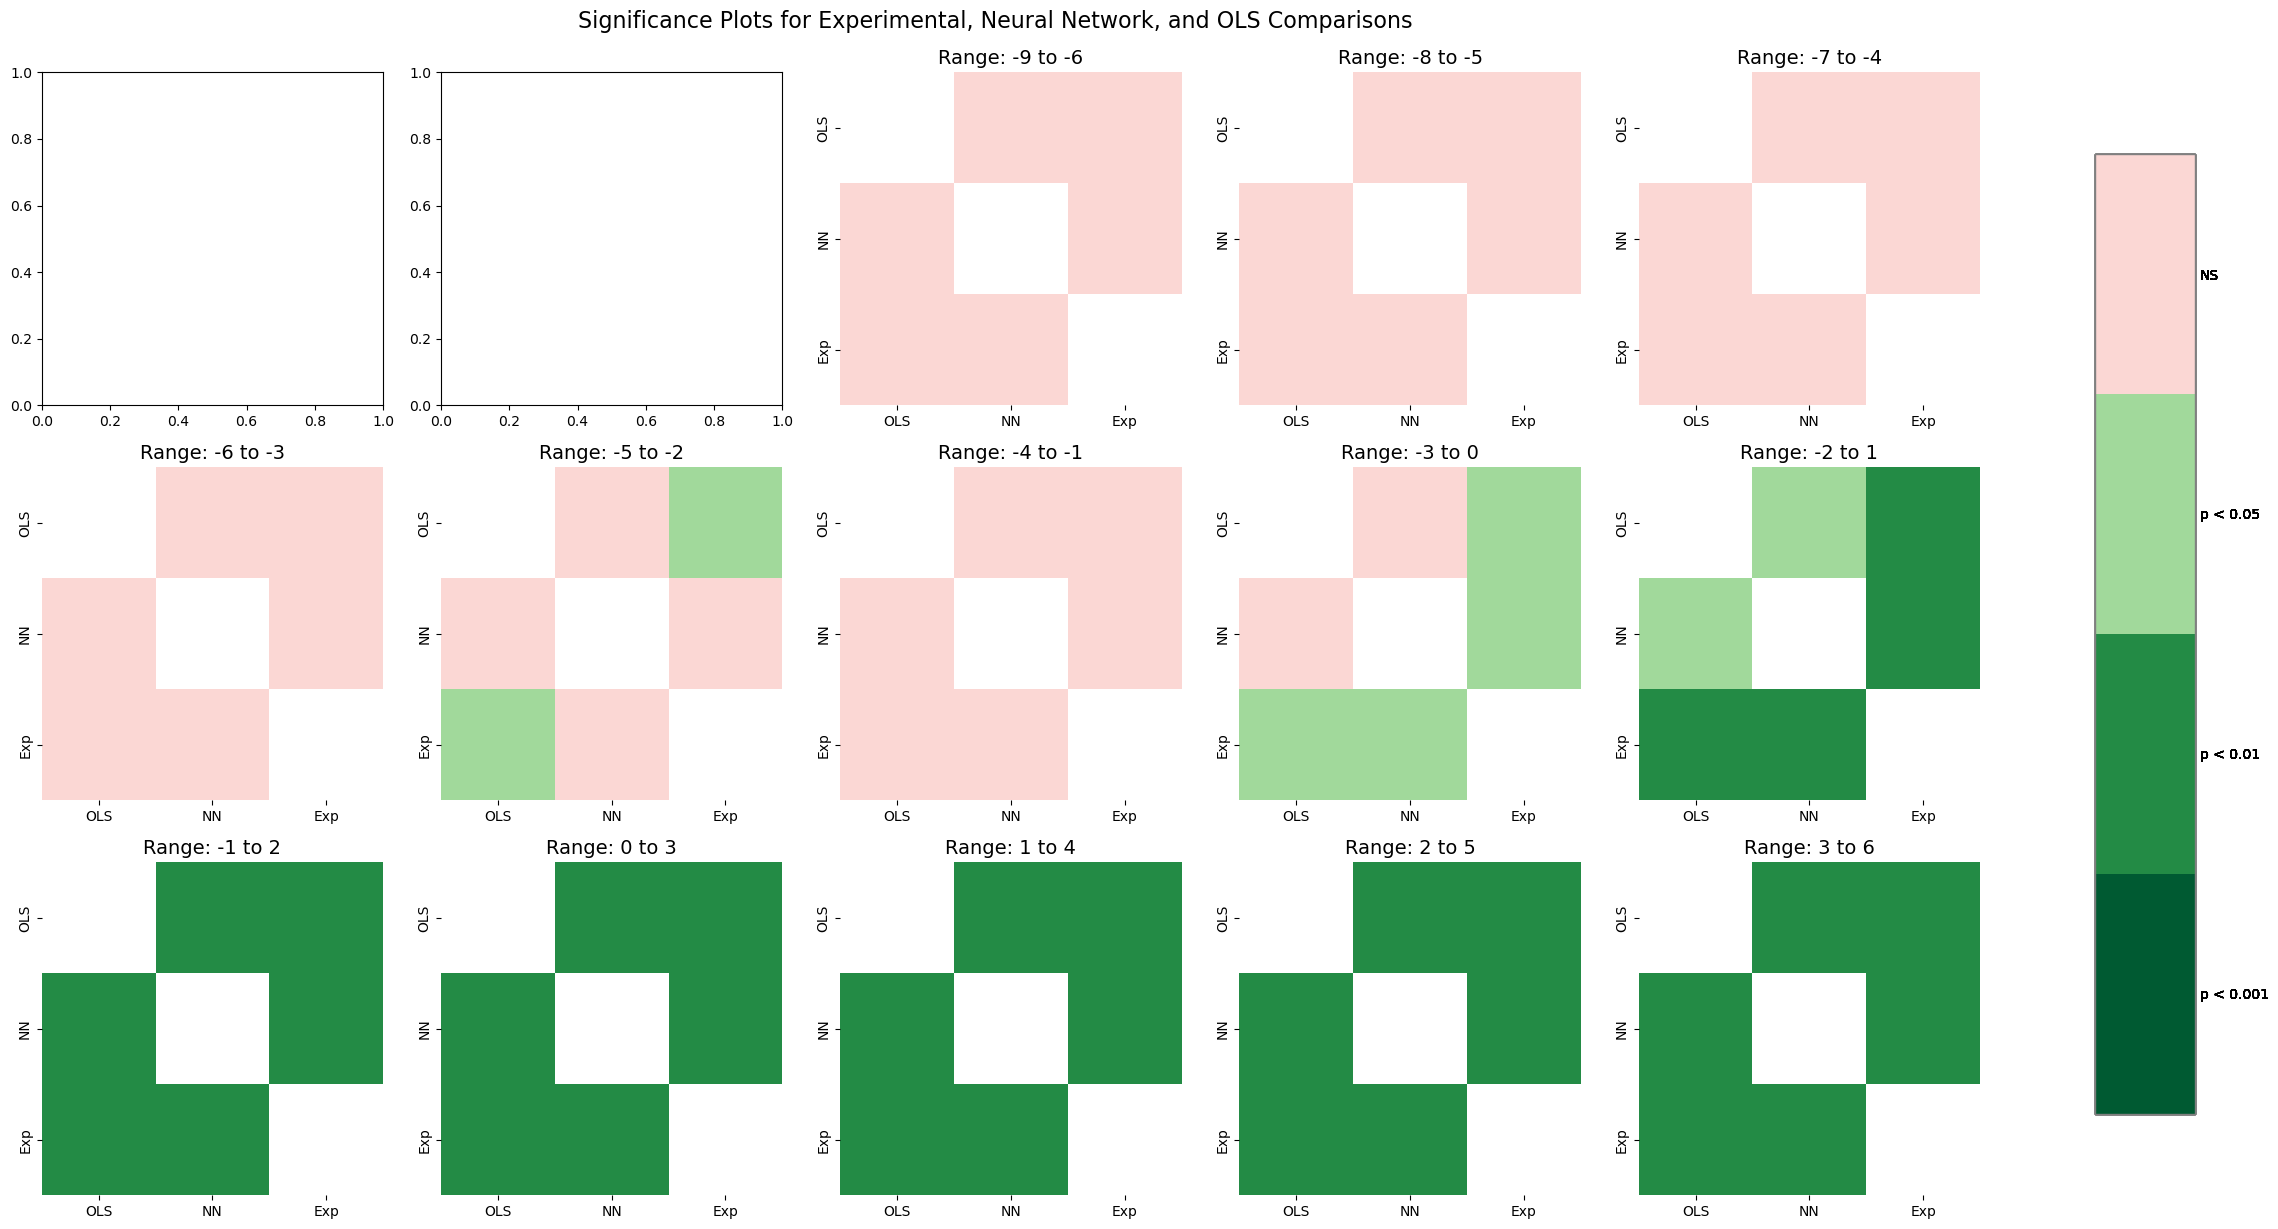

In [116]:
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import numpy as np

# Iterate over each range and create a significance plot
#keep only range starts with same value counts as max value count of range starts
max_range_start_value_count = filtered_df['Range Start'].value_counts().max()
range_start_value_counts = filtered_df['Range Start'].value_counts()
range_start_value_counts = range_start_value_counts[range_start_value_counts == max_range_start_value_count]
filtered_df = filtered_df[filtered_df['Range Start'].isin(range_start_value_counts.index)]
range_starts = sorted(filtered_df['Range Start'].unique())

fig, axes = plt.subplots(3,5, figsize=(20, 12))

for i, (ax, range_start) in enumerate(zip(axes.flatten(), range_starts)):
    subset = filtered_df[filtered_df['Range Start'] == range_start]
    ols = subset[subset['Model'] == 'Ordinary Least Squares']['All_Values'].values[0]
    nn = subset[subset['Model'] == 'NeuralNetwork']['All_Values'].values[0]
    exp = subset[subset['Model'] == 'Experimental Agreement']['All_Values'].values[0]
    try:
        assert len(ols) == len(nn) == len(exp)
    except AssertionError:
        continue


    #calculate all pair-wise comparisons, from posthocs
    data = np.array([ols, nn, exp])
    p_values = sp.posthoc_wilcoxon(data, p_adjust='bonferroni')
    p_values = p_values.to_numpy()
    #make df from p_values, with model names as columns and index
    p_values_df = pd.DataFrame(p_values, index=['OLS','NN','Exp'], columns=['OLS','NN','Exp'])
  
    # Create a significance plot
    sp.sign_plot(p_values_df, ax=ax, labels=True,cbar_ax_bbox = [1.05, 0.1, 0.05, 0.8])
    ax.set_title(f'Range: {range_start} to {range_start + 3}', fontsize=14)
    #remove legend

#remove legend
plt.tight_layout()
plt.suptitle('Significance Plots for Experimental, Neural Network, and OLS Comparisons', y=1.02, fontsize=16)
plt.show()
